# Lab 4: Introduction to Convolutional Neural Networks

## 1 Numpy Edge Detection
To build intuition about convolutions we begin by implementing an image edge detection filter in numpy.

In [109]:
!pip install scikit-image

You should consider upgrading via the 'c:\program files\python37\python.exe -m pip install --upgrade pip' command.


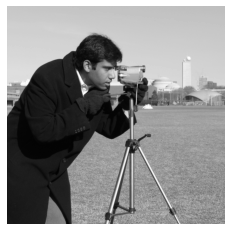

In [553]:
from skimage import data
import matplotlib.pyplot as plt

# Load and visualize a sample image
camera = data.camera()
plt.figure(figsize=(4, 4))
plt.imshow(camera, cmap='gray')
plt.axis('off')
plt.show()

In [554]:
import numpy as np

# Initialize the edge detection kernel
# kernel(numpy.array): kernel for edge detection with size of (3*3)
kernel = np.array([[-0.5, -1, -0.5],
                   [-1, 7,-1],
                   [-0.5, -1, -0.5]])
kernel = kernel / 8.0
print(f'Edge detection kernel:\n\n {kernel}')
# kernel = np.array([[ -1,0, -1],
#                     [ -2,0,2],
#                     [ -1,0,1]])


Edge detection kernel:

 [[-0.0625 -0.125  -0.0625]
 [-0.125   0.875  -0.125 ]
 [-0.0625 -0.125  -0.0625]]


### 1.1 Numpy 2D Convolution
Write a double for loop to convolve the edge detection kernel with the image. Apply the filter with `stride=2`. Plot the absolute value of the edge detection output using matplotlib's `imshow`.
Your final output should look like the image below.

<center>
<img src="https://drive.google.com/uc?id=11fFJ3QrbF87w8ChZF45p-5uXtmxZU8Qv">




## convolution2d without stride

In [561]:
def convolution2d(image, kernel):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)/m*n 
    return new_image

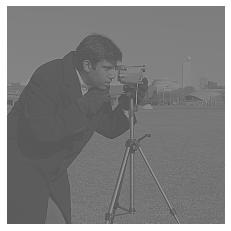

In [563]:
conv_img=convolution2d(camera,kernel)
plt.figure(figsize=(4, 4))
plt.imshow(conv_img, cmap='gray')
plt.axis('off')
plt.show()

## convolution2d with padding and stride

In [564]:
import matplotlib.pyplot as plt
# height and width of the image
H, W = camera.shape
# stride of the convolution
stride = 2
# edge detection kernel size
kernel_size = kernel.shape[0]
### TODO: convolve edge detection kernel with the camera image
output = np.zeros_like(camera)
# Add zero padding to the input image
image_padded = np.zeros((camera.shape[0] + 2, camera.shape[1] + 2))
image_padded[1:-1, 1:-1] = camera
for x in range(1,camera.shape[1]-1):
        for y in range(1,camera.shape[0]-1,2):
            # element-wise multiplication of the kernel and the image
            output[y, x]=(kernel * image_padded[y-1: y+2, x-1: x+2]).sum()/9
### TODO: plot absolute value of the output


In [565]:
image_padded[0:3,0:3]

array([[  0.,   0.,   0.],
       [  0., 200., 200.],
       [  0., 200., 199.]])

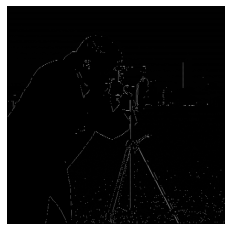

In [566]:

plt.figure(figsize=(4, 4))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

## 2 PyTorch Convolution

Now let's take a look at `torch.nn.conv2d`. Run the cell below to convolve 5 random kernels on the camera man image and see the shapes of the parameters:


In [581]:
import torch

# initialize convolutional kernel
conv_nn = torch.nn.Conv2d(1, 5, kernel_size=3, stride=2)

# set the kernel bias to zero
conv_nn.bias.data.zero_()

# convert camera image to a torch.tensor of shape (1, 1, H, W)
img_in = torch.tensor(camera, dtype=torch.float32)[None, None, :, :]

# forward pass
filtered_camera = conv_nn(img_in)

print(f'output shape (batch_size, in_channels, H, W): {filtered_camera.shape}')
print(f'kernel shape (out_channels, in_channels, kernel_size[0], kernel_size[1]): {conv_nn.weight.data.shape}\n')

# to compute the output keep in mind these variables and the formula for H,W output in torch.nn.Conv2d
print('Convolution layer parameters:')
print(f'Dilation: {conv_nn.dilation}')
print(f'Stride: {conv_nn.stride}')
print(f'Padding: {conv_nn.padding}')
print(f'Kernel size: {conv_nn.kernel_size}')
conv_nn.weight.data

output shape (batch_size, in_channels, H, W): torch.Size([1, 5, 255, 255])
kernel shape (out_channels, in_channels, kernel_size[0], kernel_size[1]): torch.Size([5, 1, 3, 3])

Convolution layer parameters:
Dilation: (1, 1)
Stride: (2, 2)
Padding: (0, 0)
Kernel size: (3, 3)


tensor([[[[-0.0971,  0.0715,  0.2754],
          [ 0.2966,  0.0746,  0.2058],
          [-0.1738, -0.0149,  0.3271]]],


        [[[-0.2795, -0.1679, -0.0721],
          [ 0.2567,  0.1417,  0.0084],
          [ 0.0892, -0.1826, -0.1126]]],


        [[[ 0.2856, -0.0011,  0.1446],
          [ 0.2733, -0.0359, -0.1102],
          [ 0.2740, -0.0183,  0.3061]]],


        [[[-0.1729,  0.1540, -0.1735],
          [ 0.1942,  0.1000,  0.2712],
          [ 0.0157, -0.0851,  0.3050]]],


        [[[-0.2468, -0.1581,  0.0964],
          [-0.1174, -0.0858,  0.1855],
          [ 0.2762, -0.0034, -0.1268]]]])

In [587]:
import copy
my_weights = copy.deepcopy(conv_nn.weight.data)
# my_weights

### 2.1 Functional 2D Convolution

Consider a minibatch of a randomly generated images (`toy_train_images`). Pass these images through the randomly initialized convolutional layer above.

Take the weights from the convolution layer above and implement the convolution using a double for loop.

**Note**: By default, PyTorch uses channels first representation of images $(N, C, H, W)$ as opposed to $(N, H, W, C)$, where $N=$ number of samples, $H=$ image height, $W=$ image width, and $C=$ number of image channels, e.g. 3 for rgb).

In [588]:
import torch.nn as nn
import copy

# toy minibatch hyperparameters
mini_batch = 10
height, width = (12, 12)
in_channels = 1
out_channels = 5

# generating minibatch from uniform distribution
toy_train_images = torch.rand(mini_batch, in_channels, height, width) 
# print(toy_train_images)

def my_conv_nn(X, kernel_weights):
    """Uses a double for loop to convolve the input image `x` with `my_weights`
    with a fixed stride of 2.

    Args:
        X (torch.Tensor): a minibatch of images of shape (batch_size, in_channels, H, W)

    Returns:
        (torch.Tensor): Convolution result

    Shape:
        - X: Of shape (N, C_in, H_in, W_in)
        - kernel_weights: Of shape (C_out, C_in, 3, 3)
        - output: (N, C_out, H_out, W_out)
    """
    np.ndarray
    my_conv_out=[]
    # convolution hyperparameters
    
    stride = 2
    ### TODO: Use for loop to implement a convolution
    idx=0
    for img in X:
        p_img=img[0]
        H, W = p_img.shape[0], p_img.shape[1]
    #   print(p_img.type)
        output = torch.zeros(int((H-2)/2),int((W-2)/2))
#         output=output.to_list()
    #   print(X.shape)
        img_conv_out=[]
        for K_W in kernel_weights :
#             print("K_W=",K_W[0])
            p_img=img[0]
            K=K_W[0]
#             print(K)
#             print(p_img)
            for i in range(1,p_img.shape[1]-1,stride):
                for j in range(1,p_img.shape[0]-1,stride):
#                     print(i,j,int(i/2),int(j/2))
                    output[int(j/2), int(i/2)] = (p_img[j-1 : j+2, i-1:i+2 ] * K).sum()/(H*W)
#                     print("p_img",p_img[j-1 : j+2, i-1:i+2 ])
#                     print("K",K)
#                     print("sum=",(p_img[j-1 : j+2, i-1:i+2 ] * K).sum()/(H*W))
            img_conv_out.append(output.numpy())
        my_conv_out.append(img_conv_out)
#     print(my_conv_out)
    return torch.from_numpy(np.array(my_conv_out))

In [589]:
# print(toy_train_images[0][0])
torch_out = conv_nn(toy_train_images)
print(torch_out.type)
# print(torch_out[0])

<built-in method type of Tensor object at 0x0000007C03AFDCC8>


In [590]:
my_weights = copy.deepcopy(conv_nn.weight.data)
my_out = my_conv_nn(toy_train_images, my_weights)
# print(my_out[0])

Confirm your custom function has the same behavior as `torch.nn.Conv2d` on the camera image.

In [591]:
my_weights = copy.deepcopy(conv_nn.weight.data)
my_out = my_conv_nn(toy_train_images, my_weights)
torch_out = conv_nn(toy_train_images)
assert my_weights.shape == (5, 1, 3, 3), f"Incorrect shape for 'my_weights' ({my_weights.shape})."
assert torch.is_tensor(my_out), "Your function output is not a torch.Tensor"
assert my_out.shape == torch_out.shape, f"Incorrect output shape ({my_out.shape})."
print(torch.norm(my_out - torch_out))
assert torch.norm(my_out - torch_out) < 100000e-3, "Incorrect function output values compared to torch module"
print('Well done! Your function has the same behaviour as torch.nn.Conv2d')

tensor(14.2490, grad_fn=<NormBackward0>)
Well done! Your function has the same behaviour as torch.nn.Conv2d


### 2.2 Modular 2D Convolution

Build a small convnet using `torch.nn.Module` with two layers and forward pass the astronaut image through it.<br> You do not need to train the model for this excercise. You should use the `torch.nn.Conv2d` for this part.

The convnet should have the following specifications:<br>

* Activation Function: `ReLU` <br>
* Layer1: filter size `(5,5)`, out_channels `16`, Stride `2` convolution layer <br>
* Layer2: `(2,2)` pooling layer <br>
* Layer3: filter size `(3,3)`, out_channels `32` convolution layer <br>
* Layer4: Linear layer with output of `5`


In your forward function add print statements to show the size of the image at each layer. 


astronaut.shape: (512, 512, 3)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


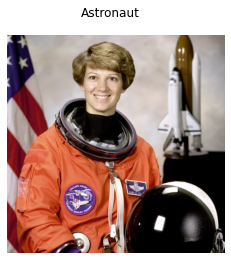

In [505]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data

# load and the astronaut image
astronaut_np = data.astronaut()
print(f"astronaut.shape: {astronaut_np.shape}")

# visualize the original and preprocessed astronaut image
# fig, ax = plt.subplots(1, 1)
fig = plt.figure()
fig.suptitle("Astronaut")
plt.imshow(astronaut_np)
plt.axis('off')
fig.show()

Run below cell to convert the astronaut image into a tensor and reshape it into the shape that PyTorch expects.

In [506]:
# convert the astronaut image to torch.tensor
astronaut = torch.tensor(astronaut_np, dtype=torch.float32)
print(astronaut.shape)
# torch convolutions expect channels first representation
# of shape (N, C, H, W)
astronaut = astronaut.permute(2, 0, 1).unsqueeze(0)
print(f'astronaut.shape: {astronaut.shape}')

torch.Size([512, 512, 3])
astronaut.shape: torch.Size([1, 3, 512, 512])


astronaut.shape: torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 16, 254, 254])
torch.Size([1, 16, 127, 127])
torch.Size([1, 16, 127, 127])
torch.Size([1, 32, 125, 125])
torch.Size([1, 32, 125, 5])


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


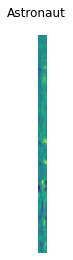

In [627]:
from skimage import data
import torch.nn.functional as F
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        ### TODO: Define layers based on description above
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.linear1 = nn.Linear(125,5)

    def forward(self, x):
        ### TODO: Compelete forward pass, print image size after each layer
        print(x.shape)
        x =  F.relu(self.conv1(x))
        print(x.shape)
        x=   F.relu(self.pool(x))
        print(x.shape)
        x=   F.relu(F.relu(x))
        print(x.shape)
        x =  F.relu(self.conv2(x))
        print(x.shape)
        x = self.linear1(x)
        print(x.shape)
        return x
    

print(f"astronaut.shape: {astronaut.shape}")

model = MyModel()
# img_in = torch.tensor(astronaut[0][0], dtype=torch.float32)[None, None, :, :]
# astronaut_processed = astronaut / 255.0
# astronaut_processed = (astronaut_processed - mean[None, :, None, None]) / std[None, :, None, None]
# forward pass
# print(img_in.shape)
out_img=model(astronaut)
fig = plt.figure()
fig.suptitle("Astronaut")
plt.imshow(out_img.detach().numpy()[0][1])
plt.axis('off')
fig.show()

## 3 Pretrained AlexNet Model


In this section, we will visualize a subset of the first layer filters of AlexNet and the result of applying these filters to the astronaut image.

Run the below cell to download the trained [AlexNet](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) model using [PyTorch Hub](https://pytorch.org/docs/stable/hub.html)'s [`torch.hub.load()`](https://pytorch.org/docs/stable/hub.html#torch.hub.load) method. The model is switched to `eval()` mode since we will not be doing any training in this lab:

In [623]:
import torch

# load the alexnet model using pytorch hub from:
# https://github.com/pytorch/vision/blob/winbuild/v0.6.0/torchvision/models/alexnet.py
lexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

# switch the model to "eval" mode since we are not doing any further training
lexnet.eval()

# print the model architecture
print(lexnet)

Using cache found in C:\Users\Administrator/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Since we are using a pretrained model, we need to make sure that our data has a similar distribution to the training data that the model was trained on. For our case here, this means that we need to preprocess the data in a similar manner to how it was done in the [original training pipeline](https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198).

Run the below cell to preprocess and visualize the astronaut image.

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


torch.Size([1, 3, 512, 512])

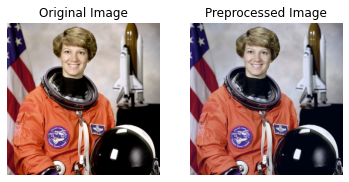

In [624]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data

def image_normalizer(image):
    r"""Normalizes the input to scale [0 1].

    Args:
        image (np.ndarray or torch.Tensor): image to be rescaled

    Returns:
        (np.ndarray or torch.Tensor): rescaled image

    Shape:
        - image: (*) Any shape
        - output: Same shape as input
    """
    return (image - image.min()) / (image.max() - image.min())

# the mean and standard deviations of ImageNet dataset 
# that were used for preprocessing AlexNet training data
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# preprocess the astronaut image from the part 2
astronaut_processed = astronaut / 255.0
astronaut_processed = (astronaut_processed - mean[None, :, None, None]) / std[None, :, None, None]

# visualize the original and preprocessed astronaut image
astro_processed_np = astronaut_processed.squeeze().permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Original Image")
ax[0].imshow(astronaut_np)
ax[0].axis('off')
ax[1].set_title("Preprocessed Image")
ax[1].imshow(image_normalizer(astro_processed_np))
ax[1].axis('off')
fig.show()
astronaut_processed.shape

### 3.1 Visualizing AlexNet Kernels

The kernels (filters) in the first layer of AlexNet are of size 11. Visualize a randomly selected subset of 20 of these first layer filters as well as the respective output of convolving each kernel with the astronaut image. Your answer will look something like this
<center>
<img src="https://drive.google.com/uc?id=1azdohWuo3EEO9KC0szZmJOywX54jXlPz">

torch.Size([1, 3, 512, 512])
<built-in method type of Tensor object at 0x0000007C7A5DA138>
<built-in method type of Tensor object at 0x0000007C01053F98>
64
(64, 3, 11, 11)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


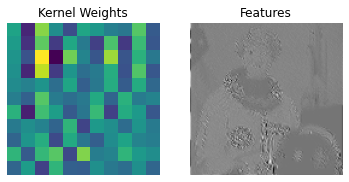

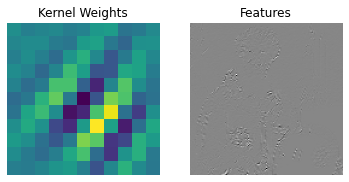

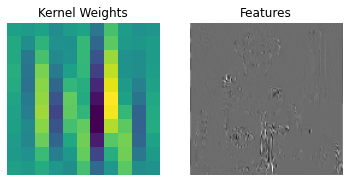

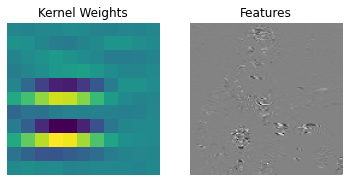

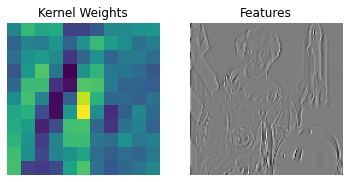

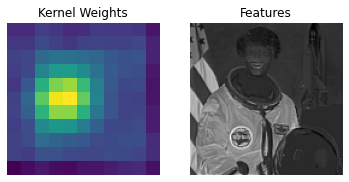

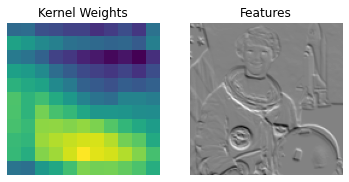

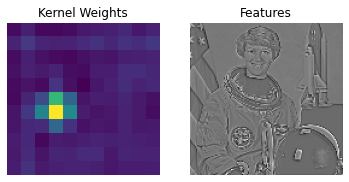

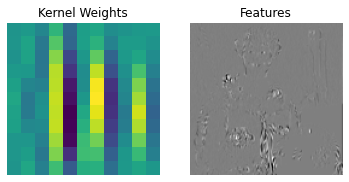

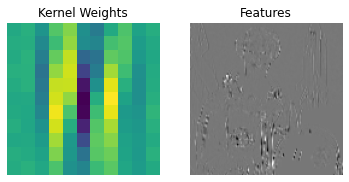

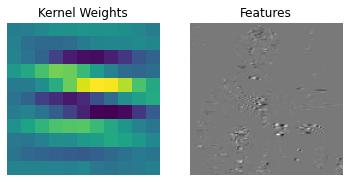

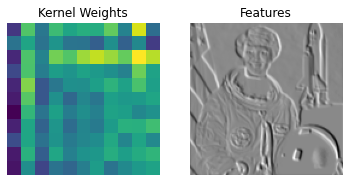

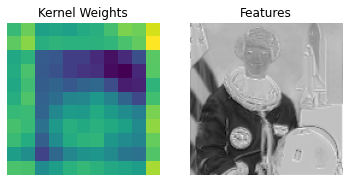

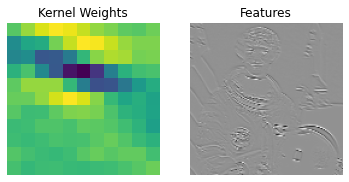

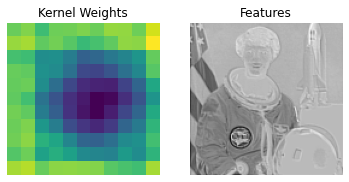

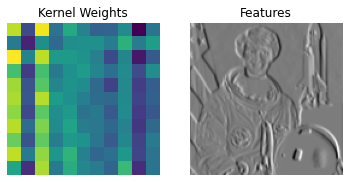

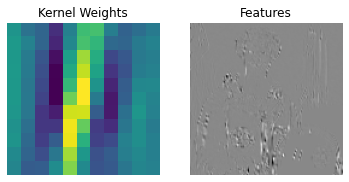

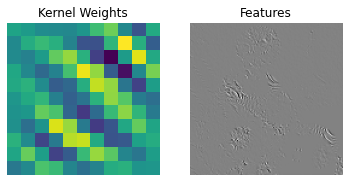

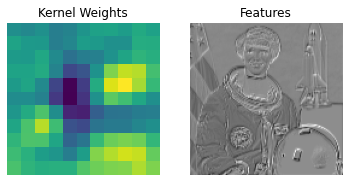

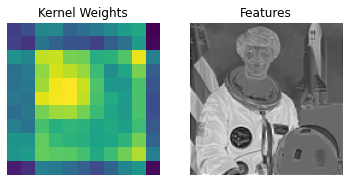

In [626]:
# conv2 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
conv2=lexnet.features[0]
# x = torch.randn(1, 3, 512, 512)
print(astronaut_processed.shape)
print(astronaut_processed.type)
print(x.type)
y = conv2(astronaut_processed.float())           # apply the convolution
y = y.detach().numpy() # convert the result into numpy
y = y[0]               # remove the dimension for batching

# normalize the result to [0, 1] for plotting
y_max = np.max(y)
y_min = np.min(y)
img_after_conv = y - y_min / (y_max - y_min)
img_after_conv.shape
print(len(img_after_conv))

np.random.seed(691)
random_inds = np.random.permutation(64)[0:20]
conv_weights = conv2.weight.detach().numpy()
print(conv_weights.shape)
for idx in random_inds :    
            fig, ax = plt.subplots(1, 2)
        
            ax[0].set_title("Kernel Weights")
            ax[0].imshow(conv_weights[idx][0])
            ax[0].axis('off')
            ax[1].set_title("Features")
            ax[1].imshow(img_after_conv[idx],cmap='gray')
            ax[1].axis('off')
            fig.show()
